Load Video

1.   Load from Google Drive in Colab
2.   Make directory



In [3]:
# Google Colab import files in google drive
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

from google.colab import auth
auth.authenticate_user()

from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()

import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
!mkdir -p drive
!google-drive-ocamlfuse drive
!cd drive; ls; 
!ls drive/FaceClustering

Preconfiguring packages ...
Selecting previously unselected package cron.
(Reading database ... 18408 files and directories currently installed.)
Preparing to unpack .../00-cron_3.0pl1-128ubuntu5_amd64.deb ...
Unpacking cron (3.0pl1-128ubuntu5) ...
Selecting previously unselected package libapparmor1:amd64.
Preparing to unpack .../01-libapparmor1_2.11.0-2ubuntu17.1_amd64.deb ...
Unpacking libapparmor1:amd64 (2.11.0-2ubuntu17.1) ...
Selecting previously unselected package libdbus-1-3:amd64.
Preparing to unpack .../02-libdbus-1-3_1.10.22-1ubuntu1_amd64.deb ...
Unpacking libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Selecting previously unselected package dbus.
Preparing to unpack .../03-dbus_1.10.22-1ubuntu1_amd64.deb ...
Unpacking dbus (1.10.22-1ubuntu1) ...
Selecting previously unselected package dirmngr.
Preparing to unpack .../04-dirmngr_2.1.15-1ubuntu8.1_amd64.deb ...
Unpacking dirmngr (2.1.15-1ubuntu8.1) ...
Selecting previously unselected package distro-info-data.
Preparing to unpack .

In [7]:
!pip install tqdm
from tqdm import tqdm
import cv2 as cv
import numpy as np
import os
import datetime
from matplotlib import pyplot as plt
%matplotlib inline
import shutil

VIDEO_DIR = 'drive/FaceClustering/'
VIDEO_FILE_NAME = 'PowerUp.mp4'
# PROGRAM_START_TIME = datetime.datetime.now().strftime('%Y%m%d_%H-%M-%S')
# PROGRAM_START_TIME = datetime.datetime.now().strftime('%Y%m%d')
PROGRAM_START_TIME = '20180827'
SAVE_CROPPED_FACE_DIR = 'drive/Cropped_imgs/' + PROGRAM_START_TIME + '-' + VIDEO_FILE_NAME.split('.')[0]
CASCADE_DIR = 'drive/FaceClustering/lbpcascade_frontalface_improved.xml'

criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
flags = cv.KMEANS_RANDOM_CENTERS

def make_directory(_directory_name):
    if not os.path.exists(_directory_name):
        os.makedirs(_directory_name)
        
def get_area_of_frame_face_recognition(img, face_cascade):
    grayed_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # def detectMultiScale(self, image, scaleFactor=None, minNeighbors=None, flags=None, minSize=None, maxSize=None)
    face_area = face_cascade.detectMultiScale(image=grayed_img,scaleFactor=1.3,minNeighbors=5)
    return face_area
  
def get_frame(video_capture, frame):
    video_capture.set(cv.CAP_PROP_POS_FRAMES, frame)
    ret, img = video_capture.read()
    return img, frame, ret

def save_cropped_img(img, faces, frame):
    i = 0
    if len(faces) != 0:
        for (x, y, w, h) in faces:
            iter = 0.4          
            while True:
                try:
                    face_img = img[int(y - h * iter): int(y + (1 + iter) * h),
                                   int(x - w * iter): int(x + (1 + iter) * w)]
                    if int(y - h * iter) < 0 or int(x - w * iter) < 0:
                        raise ValueError('range is false')
                    break
                except:
                    iter = iter * 0.8
                  #             cv.imwrite(SAVE_CROPPED_FACE_DIR + "/" + str(frame) + "_" + str(i) + ".jpg", img[y:y + h, x: x + w])
            try:
                cv.imwrite(SAVE_CROPPED_FACE_DIR + "/" + str(frame) + "_" + str(i) + ".jpg", cv.resize(face_img, (96, 96), interpolation=cv.INTER_AREA))
            except:
                print(int(y - h * iter))
                print(int(x - w * iter))
            i += 1

# this function show image and quit when press q or end
def show_img(img, faces):
    if len(faces) != 0:
        for (x, y, w, h) in faces:
            cv.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 1)
    cv.imshow('hello', img)
    if cv.waitKey(1) & 0xFF == ord('q'):
        return False
    else:
        return True
      
def ORB():
    img = cv.imread(SAVE_CROPPED_FACE_DIR + '/130_0.jpg')
    imgray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img2 = None
    orb = cv.ORB_create()
    kp, des = orb.detectAndCompute(img, None)
#     img2 = cv.drawKeypoints(img, kp, img2, (0, 0, 255), flags=0)
#     plt.imshow(img2)
    return kp, des 

def HarrisCorner():
    img = cv.imread(SAVE_CROPPED_FACE_DIR + '/130_0.jpg')
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    corners = cv.cornerHarris(img_gray, 2, 3, 0.04)
#     plt.figure(figsize=(6, 6))
#     plt.imshow(corners, cmap='gray')
    return coners

In [0]:
!ls drive/Cropped_imgs/

In [0]:
make_directory(SAVE_CROPPED_FACE_DIR)
m_video_capture = cv.VideoCapture(VIDEO_DIR + VIDEO_FILE_NAME)
m_face_cascade = cv.CascadeClassifier(CASCADE_DIR)
TOTAL_FRAME = m_video_capture.get(cv.CAP_PROP_FRAME_COUNT)
FRAME_STEP = 10
LOAD_FAIL = []
if len(os.listdir(SAVE_CROPPED_FACE_DIR)) == 0:
    for frame in tqdm(range(0, int(TOTAL_FRAME), FRAME_STEP)):
        img, frame, ret = get_frame(video_capture=m_video_capture, frame=frame)
        if not ret:
            LOAD_FAIL.append(frame)
            continue
        faces_area = get_area_of_frame_face_recognition(img=img, face_cascade=m_face_cascade)
        save_cropped_img(img, faces_area, frame)
    if len(LOAD_FAIL) > 0:
        print("Fail to load %d of frame(s)" % len(LOAD_FAIL))
        print(LOAD_FAIL)
else:    
    print("Directory is not empty")
    print("Already extracted in %s" % PROGRAM_START_TIME)

In [10]:
face_list = []
face_files = os.listdir(SAVE_CROPPED_FACE_DIR)
for face_file_name in tqdm(face_files):
    img = cv.imread(SAVE_CROPPED_FACE_DIR + '/' + face_file_name)
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img_blur = cv.GaussianBlur(img_gray, (3,3), 0)
    img_sharp = cv.Laplacian(img_blur, cv.CV_64F)
#     corners = cv.cornerHarris(img_gray, 2, 3, 0.04)
#     face_list.append(img_gray)
    face_list.append(img_sharp.flatten())
#     rgb_img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
#     face_list.append(rgb_img)


100%|██████████| 223/223 [00:05<00:00, 43.23it/s]

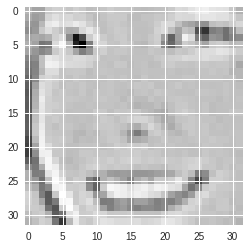

In [0]:
plt.imshow(face_list[10])

In [0]:
face_list = np.float32(face_list)


100%|██████████| 9/9 [00:04<00:00,  2.16it/s]


Text(0,0.5,'compactness')

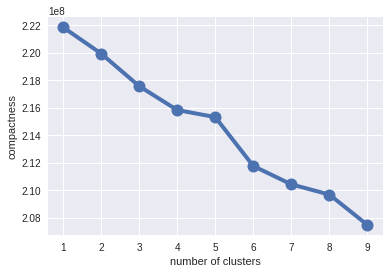

In [17]:
compactness = []
kvals = np.arange(1,10)
for k in tqdm(kvals):
    c, _, _ =  cv.kmeans(face_list, k, None, criteria, 10, flags)
    compactness.append(c)
plt.plot(kvals, compactness, 'o-', linewidth=4,
        markersize=12)
plt.xlabel('number of clusters')
plt.ylabel('compactness')

In [0]:
k = 4
compactness, clusters, centers = cv.kmeans(face_list, k, None, criteria, 10, flags)
make_directory(SAVE_CROPPED_FACE_DIR + "_cluster_" + str(k))
for i in range(k):
    make_directory(SAVE_CROPPED_FACE_DIR + "_cluster_" + str(k) + '/' + str(i))

In [0]:
for f_n, c_k in tqdm(zip(face_files, clusters)):
    print(f_n, c_k )
    shutil.copy2(SAVE_CROPPED_FACE_DIR + '/' + f_n, SAVE_CROPPED_FACE_DIR + "_cluster_" + str(k) + '/' + str(c_k[0]) + '/' + f_n)

In [0]:
def cluster(face_list):
     encodings = face_list

     clt = DBSCAN(metric="euclidean")
     clt.fit(encodings)

     label_ids = np.unique(clt.labels_)
     num_unique_faces = len(np.where(label_ids > -1)[0])

     for label_id in label_ids:
         dir_name = "drive/ID%d" % label_id
         os.mkdir(dir_name)

         indexes = np.where(clt.labels_ == label_id)[0]

         for i in  tqdm(indexes):
             frame_id = face_list[i].frame_id
             box = face_list[i].box
             pathname = os.path.join(self.capture_dir,
                                     self.capture_filename(frame_id))
             image = cv2.imread(pathname)
             face_image = self.getFaceImage(image, box)
             filename = dir_name + "-" + self.capture_filename(frame_id)
             pathname = os.path.join(dir_name, filename)
             cv2.imwrite(pathname, face_image)

In [22]:
face_list[0]

array([ -8., -32., -36., ...,  29.,  -1., -48.], dtype=float32)

In [0]:
from sklearn.cluster import DBSCAN
clt = DBSCAN(metric="euclidean")
clt.fit(face_list)

label_ids = np.unique(clt.labels_)
num_unique_faces = len(np.where(label_ids > -1)[0])

In [24]:
label_ids

array([-1])

In [25]:
clt.labels_

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1])